# Analyse quantisation of weights in real models

General:

- name
- shape
- moments
  - mean
  - std
  - rms
  - rm4
- abs-value/rms histogram -- for bin in range(1, 21)
  - also for /rms(input) and /rms(output)
- mean of group max -- for g in 2**range(1, 1+log(n))
- quantisation MSE
  - group size -- 2**range(1, 1+log(n))
  - formats
    - tensor amax -- {int, fp}
    - tensor std -- {gauss, laplace}
    - channel amax -- {int, fp}
    - channel std -- {gauss, laplace}
    - group symmetric -- {int, fp, nf4, gauss, laplace}
    - group asymmetric -- {int, gauss, laplace}

Special:

 - shuffle weight order -- {no, yes}
 - zero point -- {no, yes}
 - group mantissa bits -- range(0, 8)

In [43]:
%load_ext autoreload
%autoreload 2

from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import tqdm
import torch
from torch import tensor, Tensor
import transformers
from typing import Any, Literal

import quantisation.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

DEFAULT_DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def sample(n: int, distribution: Literal["normal", "laplace"], device: torch.device = DEFAULT_DEVICE) -> Tensor:
    dist = dict(normal=torch.distributions.Normal,
                laplace=torch.distributions.Laplace)[distribution]
    return dist(tensor(0., device=device), tensor(1., device=device)).sample((n,))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tests

In [2]:
torch.manual_seed(100)
x = torch.randn(2**24, device="cuda")
lm = Q.lut_lloyd_max(x, 4, iterations=100)
print(lm, Q.snr(x, lm.quantise(x)))
crp = Q.crp_gauss(4)
print(crp, Q.snr(x, crp.quantise(x)))

LUT4[LM] tensor(105.2750, device='cuda:0')
LUT4[CRP-G] tensor(105.2527, device='cuda:0')


In [3]:
torch.manual_seed(100)
x = torch.distributions.Laplace(torch.tensor(0., device="cuda"), torch.tensor(1., device="cuda")).sample((2**24,))
lm = Q.lut_lloyd_max(x, 4, iterations=100)
print(lm, Q.snr(x, lm.quantise(x)))
crp = Q.crp_laplace(4)
print(crp, Q.snr(x, crp.quantise(x)))

LUT4[LM] tensor(65.1139, device='cuda:0')
LUT4[CRP-L] tensor(65.0639, device='cuda:0')


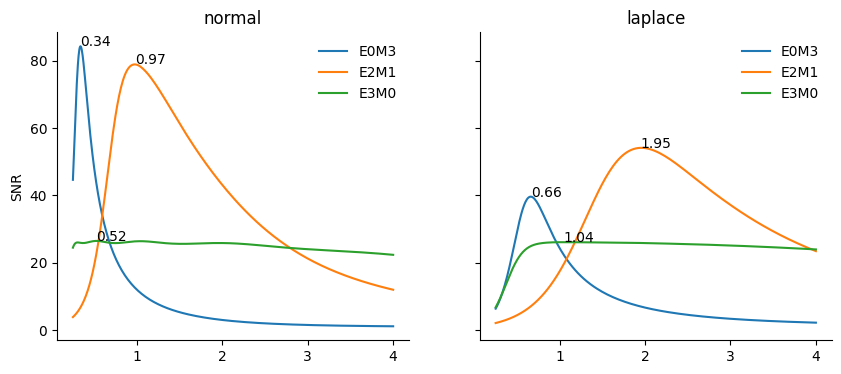

In [43]:
torch.manual_seed(100)
_, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for dist, ax in zip(["normal", "laplace"], axs):
    x = sample(2**24, dist)
    mult = 2**torch.arange(-2, 2+0.01, 0.02)
    for fmt in [Q.parse("E0M3"), Q.parse("E2M1"), Q.parse("E3M0")]:
        snr = [Q.snr(x, Q.ScaledFormat(fmt, m).quantise(x)).item() for m in mult]
        ax.plot(mult, snr, label=str(fmt))
        ax.legend()
        ax.set_title(dist)
        best_mult, best_snr = max(zip(mult, snr), key=lambda p: p[1])
        ax.annotate(f"{best_mult:.2f}", [best_mult, best_snr])
axs[0].set_ylabel("SNR");

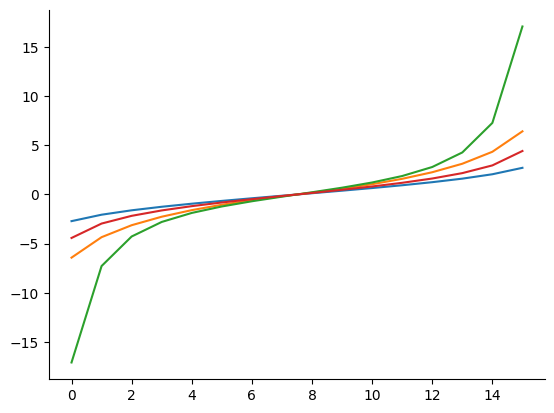

In [162]:
plt.plot(Q.crp_gauss(4).values)
plt.plot(Q.crp_laplace(4).values)
plt.plot(Q.crp_t(4, 4.5).values)
plt.plot(Q.crp_t(4, 10).values)

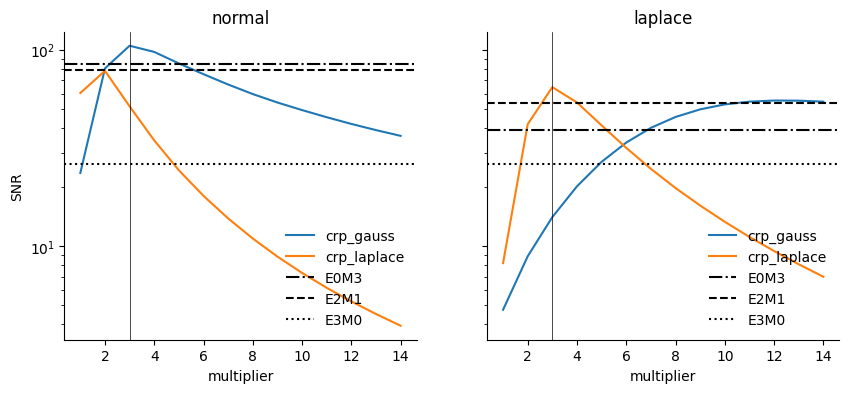

In [48]:
n = 2**20
_, axs = plt.subplots(ncols=2, figsize=(10, 4),sharey=True)
for dist, ax in zip(["normal", "laplace"], axs):
    if dist == "normal":
        x = torch.randn(n)
    if dist == "laplace":
        x = torch.distributions.Laplace(0, 1).sample((n,))
    mults = torch.arange(1, 15)
    for method in [Q.crp_gauss, Q.crp_laplace]:
        ax.plot(mults, [Q.snr(x, method(4, multiplier=m).quantise(x)) for m in mults], label=method.__name__)
    ax.axhline(Q.snr(x, Q.ScaledFormat(Q.parse("E0M3"), dict(normal=1/3, laplace=2/3)[dist]).quantise(x)), color="k", ls="-.", label="E0M3")
    ax.axhline(Q.snr(x, Q.ScaledFormat(Q.parse("E2M1"), dict(normal=1, laplace=2)[dist]).quantise(x)), color="k", ls="--", label="E2M1")
    ax.axhline(Q.snr(x, Q.parse("E3M0").quantise(x)), color="k", ls=":", label="E3M0")
    ax.axvline(3, color="k", lw=0.5)
    ax.set_yscale("log")
    ax.legend(loc="lower right")
    ax.set_title(dist)
    ax.set_xlabel("multiplier")
axs[0].set_ylabel("SNR");

## Actual weights

In [41]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct", device_map=DEFAULT_DEVICE, torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

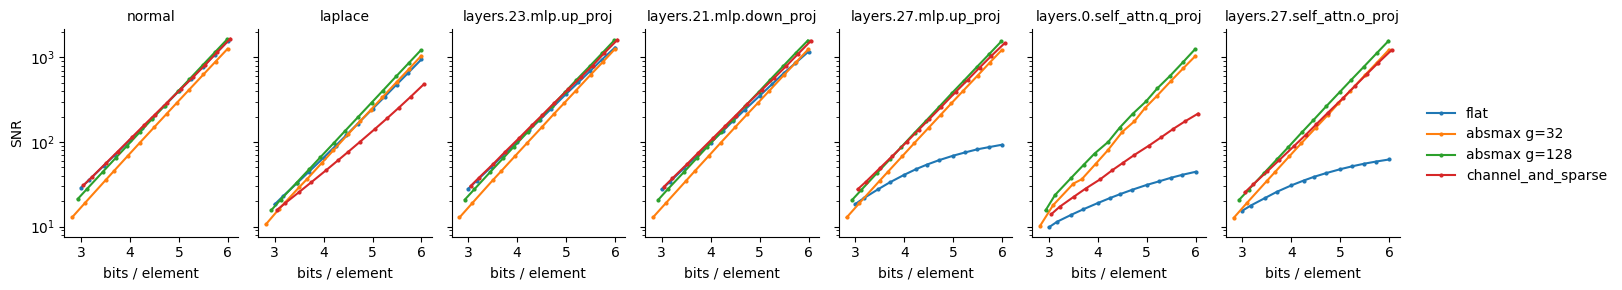

In [ ]:
torch.manual_seed(100)
cols = ["normal", "laplace",
        "model.layers.23.mlp.up_proj.weight",
        "model.layers.21.mlp.down_proj.weight",
        "model.layers.27.mlp.up_proj.weight",
        "model.layers.0.self_attn.q_proj.weight",
        "model.layers.27.self_attn.o_proj.weight",
]
fig, axs = plt.subplots(ncols=len(cols), figsize=(2*len(cols), 3),sharey=True)
for dist, ax in zip(cols, axs):
    if dist in ["normal", "laplace"]:
        x = sample(2**20, dist)
    else:
        x = dict(model.named_parameters())[dist].flatten().to(DEFAULT_DEVICE)
        x = x / x.pow(2).mean().sqrt()

    crp_method = dict(normal=Q.crp_gauss, laplace=Q.crp_laplace).get(dist, Q.crp_gauss)  # partial(Q.crp_t, dof=4.5)
    fmts = [crp_method(b) for b in torch.linspace(3, 6, 13)]
    ax.plot([fmt.count_bits(x.shape) / x.nelement() for fmt in fmts],
            [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts], label="flat", marker='o', ms=2)

    for g in [32, 128]:
        crp_method = dict(normal=Q.crp_trunc_gauss, laplace=Q.crp_trunc_laplace).get(dist, Q.crp_trunc_gauss)
        fmts = [Q.LinearScalingFormatV2(crp_method(b, g, symmetric=False), Q.BFLOAT16, (g,), "signmax")
                for b in torch.linspace(3 - 16/g, 6 - 16/g, 13)]
        ax.plot([fmt.count_bits(x.shape) / x.nelement() for fmt in fmts],
                [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts], label=f"absmax g={g}", marker='o', ms=2)

    fmts = [Q.ChannelAndSparseFormat(Q.crp_gauss(b), Q.BFLOAT16, 0, Q.BFLOAT16, 0.001)
            for b in torch.linspace(3, 6, 13)]
    ax.plot([fmt.count_bits(x[None].shape) / x.nelement() for fmt in fmts],
            [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts], label="channel_and_sparse", marker='o', ms=2)

    ax.set_yscale("log")
    ax.set_title(dist.replace("model.", "").replace(".weight", ""), fontsize=10)
    ax.set_xlabel("bits / element")
fig.tight_layout()
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("SNR");

### Stats

In [4]:
def mean_group_amax(w: Tensor, g: int) -> Tensor:
    w = w.flatten()
    return w[:g*(w.nelement()//g)].view(-1, g).abs().amax(1).mean()


def get_stats(w: Tensor) -> dict[str, Any]:
    w = w.float()
    rm2 = w.pow(2).mean().sqrt()
    hist_bins = torch.arange(1, 20 + 1, device=w.device)
    return dict(
        shape=tuple(w.shape),
        mean=w.mean().item(),
        std=w.std().item(),
        rm2=rm2.item(),
        rm4=w.div(rm2).pow(4).mean().pow(1/4).mul(rm2).item(),
        max=w.abs().amax().item(),
        gmax=[
            mean_group_amax(w, g).item()
            for g in 2**torch.arange(0, int(tensor(w.nelement()).log2().ceil()))
        ],
        hist=torch.bucketize(w.div(rm2).flatten().abs(), hist_bins).bincount(minlength=hist_bins.shape[0] + 1).div(w.nelement()).tolist(),
        channel_hist=[
            torch.bucketize(
                w.div(w.pow(2).mean(dim=tuple(d for d in range(w.ndim) if d != dim), keepdim=True).sqrt()).flatten().abs(),
                hist_bins
            ).bincount(minlength=hist_bins.shape[0] + 1).div(w.nelement()).tolist()
            for dim in range(w.ndim)
        ]
    )


stats = [dict(name=name.replace("model.", ""), **get_stats(w)) for name, w in tqdm.tqdm(list(model.named_parameters()))]

  0%|          | 0/254 [00:00<?, ?it/s]

100%|██████████| 254/254 [00:03<00:00, 83.15it/s] 


In [93]:
df = pd.DataFrame.from_records(stats)
df["rank"] = df["shape"].apply(len)
df["cv"] = df["std"] / df["mean"].abs()
df["ukurt"] = df["rm4"] / df["rm2"]
df["outliers"] = df["hist"].apply(lambda h: tensor(h)[5:].sum().item())
df["out_outliers"] = df["channel_hist"].apply(lambda h: tensor(h[0])[5:].sum().item())
df["in_outliers"] = df["channel_hist"].apply(lambda h: tensor(h[-1])[5:].sum().item())
df[df["rank"] == 2].sort_values("outliers")[["name", "shape", "rm2", "rm4", "max", "outliers", "out_outliers", "in_outliers"]]

,name,shape,rm2,rm4,max,outliers,out_outliers,in_outliers
57,layers.6.self_attn.v_proj.weight,"(1024, 3072)",0.012661,0.017094,0.089844,0.000007,0.000006,0.000047
214,layers.23.mlp.down_proj.weight,"(3072, 8192)",0.018223,0.024520,0.714844,0.000010,0.000018,0.000011
196,layers.21.mlp.down_proj.weight,"(3072, 8192)",0.018229,0.024411,0.566406,0.000011,0.000024,0.000015
205,layers.22.mlp.down_proj.weight,"(3072, 8192)",0.018305,0.024556,0.652344,0.000012,0.000026,0.000013
213,layers.23.mlp.up_proj.weight,"(8192, 3072)",0.018399,0.024392,0.243164,0.000013,0.000017,0.000027
...,...,...,...,...,...,...,...,...
245,layers.27.self_attn.k_proj.weight,"(1024, 3072)",0.024446,0.038648,0.570312,0.000732,0.000594,0.000127
13,layers.1.self_attn.o_proj.weight,"(3072, 3072)",0.013862,0.023632,0.419922,0.000803,0.000238,0.000725
236,layers.26.self_attn.k_proj.weight,"(1024, 3072)",0.024232,0.039623,0.455078,0.001145,0.001017,0.000100
2,layers.0.self_attn.k_proj.weight,"(1024, 3072)",0.041362,0.072069,0.953125,0.001470,0.000460,0.000538


In [120]:
w = dict(model.named_parameters())["model.layers.0.self_attn.q_proj.weight"]
efmt = Q.parse("E0M3")
# efmt = Q.parse("E2M1")
# efmt = Q.crp_gauss(4)
# efmt = Q.crp_laplace(4)
# efmt = Q.crp_trunc_gauss(4, 64, True)
# efmt = Q.crp_trunc_laplace(4, 64, True)
# efmt = Q.NF4
print(Q.snr(w, torch.compile(Q.LinearScalingFormatV2(efmt, Q.BFLOAT16, (1, None), "absmax").quantise)(w)))  # =>
print(Q.snr(w, torch.compile(Q.LinearScalingFormatV2(efmt, Q.BFLOAT16, (1, 64), "absmax").quantise)(w)))  # =>
print(Q.snr(w, torch.compile(Q.LinearScalingFormatV2(efmt, Q.BFLOAT16, (None, 1), "absmax").quantise)(w)))  # =>
print(Q.snr(w, torch.compile(Q.LinearScalingFormatV2(efmt, Q.BFLOAT16, (64, 1), "absmax").quantise)(w)))  # =>

tensor(23.3750, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(66.5000, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(14.2500, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(62.2500, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)


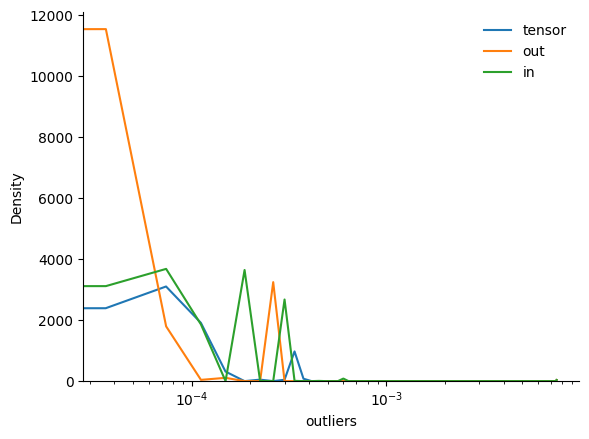

In [21]:
sns.kdeplot(df.outliers, label="tensor", bw_method=1e-3)
sns.kdeplot(df.out_outliers, label="out", bw_method=1e-3)
sns.kdeplot(df.in_outliers, label="in", bw_method=1e-3)
plt.legend()
plt.xscale("log")

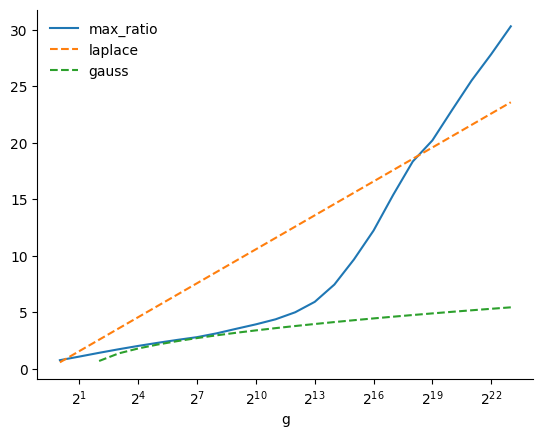

In [71]:
s = df[df.name=="layers.1.self_attn.o_proj.weight"].iloc[0]
d = pd.DataFrame.from_records(s.gmax)
d["max_ratio"] = d["max"] / s["std"]
ax = d.plot(y="max_ratio", x="g")
ax.plot(d.g, 0.577 + tensor(d.g).log2(), label="laplace", ls="--")
ax.plot(d.g, tensor(d.g).div(torch.pi).log().mul(2).sqrt(), label="gauss", ls="--")
ax.legend()
ax.set_xscale("log", base=2)
# ax.xaxis.set_major_formatter("{x:.0f}")

### Single-weight analysis

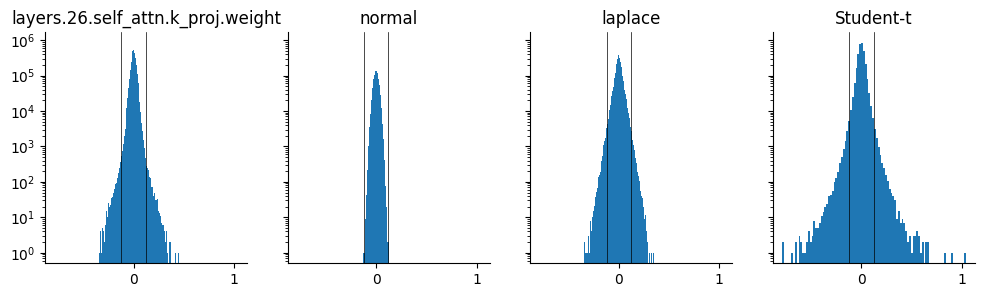

In [166]:
params = dict(model.named_parameters())
key = "model.embed_tokens.weight"
key = "model.layers.27.mlp.up_proj.weight"
key = "model.layers.0.self_attn.q_proj.weight"
key = "model.layers.26.self_attn.k_proj.weight"

_, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True)
w = params[key].detach().cpu().float()
ax0.hist(w.flatten(), bins=100)
ax0.set_title(key.replace("model.", ""))
ax1.hist(torch.randn(w.nelement()) * w.std(), bins=100)
ax1.set_title("normal")
ax2.hist(torch.distributions.Laplace(0, w.std()).sample((w.nelement(),)), bins=100)
ax2.set_title("laplace")
ax3.hist(torch.distributions.StudentT(4.5, scale=w.std()).sample((w.nelement(),)), bins=100)
ax3.set_title("Student-t")

for ax in [ax0, ax1, ax2, ax3]:
    ax.set_yscale("log")
    wstd = w.std()
    ax.axvline(-5 * wstd, color="k", lw=0.5)
    ax.axvline(5 * wstd, color="k", lw=0.5)

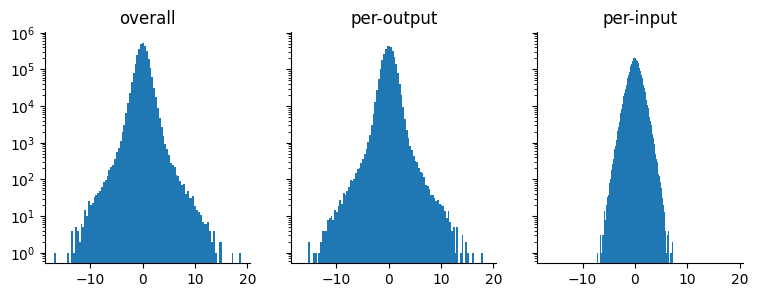

In [167]:
w_outnorm = w / w.pow(2).mean(dim=1, keepdims=True).sqrt()
w_innorm = w / w.pow(2).mean(dim=0, keepdims=True).sqrt()
_, axs = plt.subplots(ncols=3, figsize=(9, 3), sharey=True, sharex=True)
axs[0].hist(w.flatten() / w.pow(2).mean().sqrt(), bins=100)
axs[0].set_title("overall")
axs[1].hist(w_outnorm.flatten(), bins=100)
axs[1].set_title("per-output")
axs[2].hist(w_innorm.flatten(), bins=100)
axs[2].set_title("per-input")
for ax in axs:
    ax.set_yscale("log")